# Import Parcels Stuffs

In [1]:
from parcels import Field, FieldSet, ParticleSet, JITParticle, Variable, ErrorCode, AdvectionRK4
from netCDF4 import Dataset
import numpy as np
import math
import datetime
from datetime import timedelta
from operator import attrgetter

# Import Copernicus Data

In [2]:
globfiles = "/Volumes/MIKES_DISK/CMEMS/2014_CMEMS.nc"
filenames = {'U': globfiles,
             'V': globfiles}

variables = {'U': 'uo',
             'V': 'vo'}

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=True)


# Creating the Adult Turtle Advection Kernel

In [3]:
def adult_turtle_advection(particle,fieldset,time):
    
    """Following Jones et al 2011 and the,
    x = 3.5 × 10, standard used for Adult Turtles
    presented in Gaspar et al 2012, Oceanic dispersal 
    of juvenile leatherback turtles: going beyond 
    passive drift modeling"""
    
    a = 1
    a += (particle.age/365/24)
    # a will be in years
    
    scl = 1.43*(1 - math.e**(-(0.226*(a + 0.17))))
    x = 3.5 * 10**4
    
    d = x*scl*(a)
    # d is now the distance travelled meters per year
    
    d_h = d/(365*24)
    # d_h is now in meters per hour
    
    d_d = d_h / 1000. / 1.852 / 60.
    # d_d is now in degrees per hour
    
    d_dt = d_d * particle.dt
    # now the step is for every particle.dt (I normally use hours but its probably good to come
    # up with a way of converting this.)
    
    particle.lat += random.uniform(-1., 1.) * (((d_dt/2)**2)**0.5)
    particle.lon += random.uniform(-1., 1.) * (((d_dt/2)**2)**0.5)
    # adding the distance to the particle position. At the moment this is just in a random direction
    

def DeleteParticle(particle, fieldset, time):
    particle.delete()    

In [4]:
particle_age = 10
# give the turtles a start age in years. 

In [5]:
class Turtle(JITParticle):
    age = Variable('age', dtype=np.float32, initial=particle_age)

lonW = 23.7714
lonE = 23.7714
latS = -36.28236
latN = -36.28236


particles = 15

lons, lats = np.meshgrid(np.linspace(lonW,lonE,np.sqrt(particles)), 
                         np.linspace(latN,latS,np.sqrt(particles)))
pset = ParticleSet.from_list(fieldset=fieldset, pclass=Turtle, lon=lons, lat=lats,
                            time = datetime.datetime(2014,2,15))

kernels = (pset.Kernel(AdvectionRK4)+ adult_turtle_advection)

output_file = pset.ParticleFile(name="adult_turtle"
                                ,outputdt=timedelta(hours=6))

pset.execute(kernels, runtime=timedelta(days=100),
             dt=timedelta(hours=6),output_file=output_file,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled TurtleAdvectionRK4adult_turtle_advection ==> /var/folders/r4/54mc4t2559d_d1fnkl99m38r0000gn/T/parcels-501/48f5001f1664233a7ae5029866473e24_0.so
INFO: Temporary output files are stored in out-KHYTRLLO.
INFO: You can use "parcels_convert_npydir_to_netcdf out-KHYTRLLO" to convert these to a NetCDF file during the run.
100% (8640000.0 of 8640000.0) |##########| Elapsed Time: 0:04:26 Time:  0:04:26


# Plot the Data

In [7]:
import xarray as xr
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import cartopy.feature as cfeature

%pylab inline

# nc.close()
nc = xr.open_dataset("adult_turtle.nc")

Populating the interactive namespace from numpy and matplotlib


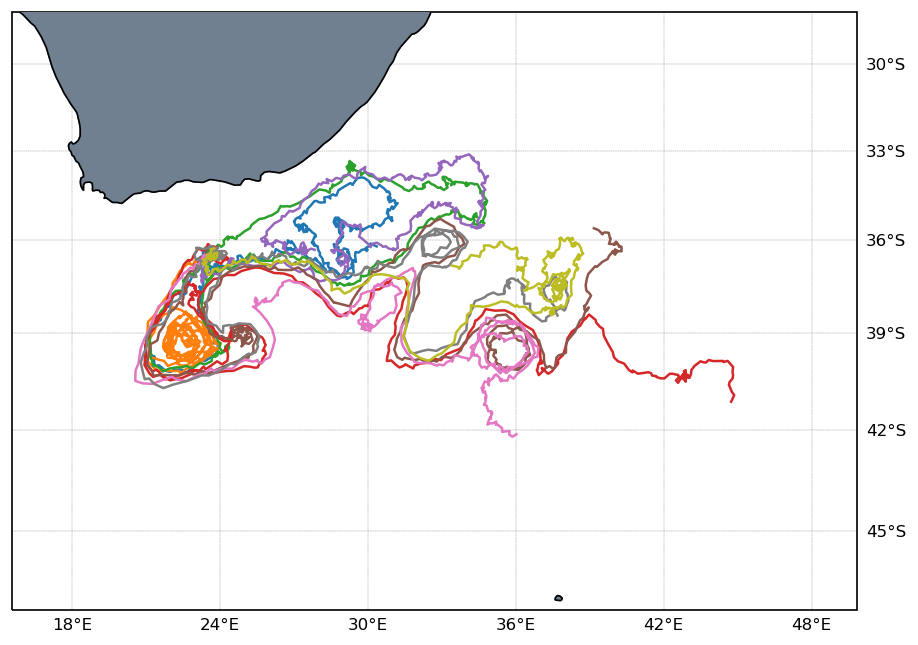

In [8]:
proj=ccrs.Mercator()
pc = ccrs.PlateCarree()

fig = plt.figure(figsize=(20, 12),dpi=120)

res = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', res,
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
dc = xr.open_dataset("drifter_145_traj.nc",decode_times=False)
lon = np.array(dc.lon)
lat = np.array(dc.lat)

extent=[np.nanmin(nc.lon)-5, 
        np.nanmax(nc.lon)+5,
        np.nanmin(nc.lat)-5,
        np.nanmax(nc.lat)+5]

proj=ccrs.Mercator()
ax = plt.subplot(1,2,1, projection=proj)
pc = ccrs.PlateCarree()

ax.set_extent(extent, pc)
ax.add_feature(land, facecolor='slategray',zorder=10)
ax.coastlines(resolution=res, zorder=11) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.25, 
                  color='gray', alpha=1, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = True
gl.ylabels_left = False
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

ax.plot(nc.lon.T,nc.lat.T,transform=pc)
plt.show()